# Loading The Data

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import shuffle


(x_train_raw, y_train_raw), (x_test_raw, y_test_raw) = tf.keras.datasets.fashion_mnist.load_data()


4423680/4422102 [==============================] - 1s 0us/step


In [2]:
x_train_raw.shape, y_train_raw.shape, x_test_raw.shape, y_test_raw.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

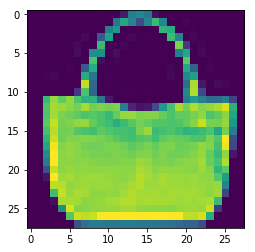

In [3]:
plt.imshow(x_train_raw[100])

In [4]:
x_train = np.reshape(x_train_raw, [x_train_raw.shape[0], x_train_raw.shape[1]*x_train_raw.shape[2]])
x_test = np.reshape(x_test_raw, [x_test_raw.shape[0], x_test_raw.shape[1]*x_test_raw.shape[2]])

n_values = np.max(y_train_raw) + 1
y_train_onehot = np.eye(n_values)[y_train_raw]
y_test_onehot = np.eye(n_values)[y_test_raw]



In [5]:
#Run the commented lines if you are using Colab for running the code. Ignore it if you are running Jupyter Notebook locally
#!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
#!unzip ngrok-stable-linux-amd64.zip

LOG_DIR = './log/'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

#get_ipython().system_raw('./ngrok http 6006 &')

#! curl -s http://localhost:4040/api/tunnels | python3 -c \
#    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

# Getting Started with Tensorflow

In [6]:
#Tensorflow creates a computation graph first for the computations you want to perform.
#consider a function that does simple addition and multiplication
#For instace we want to compute a = (2b+c), where b = 2 and c = 3 
g1 = tf.Graph()
with g1.as_default():
  b = tf.constant(2, name="b")
  c = tf.constant(3, name="c")
  a = tf.math.add(tf.scalar_mul(2,b), c)


In [7]:
#Then, we can execute the computation graph in a session
with tf.Session(graph=g1) as sess:
  writer = tf.summary.FileWriter("./log/graph_addition", sess.graph) #to visualize the graph
  a_val = sess.run(a) #executing the graph. The items you want to evaluate are passed as arguements to the function
  print(a_val)
  writer.close()

7


In [8]:
#What if we want to pass the value to the constants b and c when executing the graph?
#We use place_holders instead of hardcoding the values when making the graph and pass the values to the place_holders when running the graph
g2 = tf.Graph()
with g2.as_default():
  b = tf.placeholder(dtype=tf.float32, shape=(), name='b')
  c = tf.placeholder(dtype=tf.float32, shape=(), name='c')
  a = tf.math.add(tf.scalar_mul(2,b), c)

with tf.Session(graph=g2) as sess:
  writer = tf.summary.FileWriter("./log/graph_addition2", sess.graph) #to visualize the graph
  a_val = sess.run(a, feed_dict={b:2, c:3}) 
  print(a_val)
  writer.close()


7.0


# Multi-Class Classification with a Single Layer

In [9]:
#Creating the computation graph for the model here.
g3 = tf.Graph()
with g3.as_default():
  x = tf.placeholder(dtype=tf.float64, shape=[None, int(x_train.shape[1])], name='x')
  y = tf.placeholder(dtype=tf.float64, shape=[None, int(y_train_onehot.shape[1])], name='y')
  #tf.cast(tf.constant(np.reshape(x_train[0], [1, int(x_train[0].shape[0])]), name="x"), tf.float64)
  
  W = tf.Variable(np.random.rand(int(x.shape[1]), 10), name="W")
  b = tf.Variable(np.random.rand(10), name="b")

  # Construct a linear model
  net_out = tf.matmul(x, W) + b
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=net_out))
  optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(loss)
  
  correct_pred = tf.equal(tf.argmax(net_out, 1), tf.argmax(y, 1))
  accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [10]:
no_epochs = 10
no_minibatches = 1000
minibatch_size = int(x_train.shape[0]/no_minibatches)
sum_accuracy_val=0
with tf.Session(graph=g3) as sess:
  sess.run(tf.global_variables_initializer())
  writer = tf.summary.FileWriter("./log/graph_single", sess.graph)
  for j in range(no_epochs):
    x_train, y_train_onehot = shuffle(x_train, y_train_onehot)    
    for i in range(no_minibatches):
      x_batch = x_train[i*minibatch_size:(i+1)*minibatch_size]
      y_batch = y_train_onehot[i*minibatch_size:(i+1)*minibatch_size]
      _, accuracy_val = sess.run([optimizer, accuracy], feed_dict={x:x_batch, y:y_batch})
      sum_accuracy_val = sum_accuracy_val + accuracy_val 
      
    print(sum_accuracy_val/no_minibatches)
    sum_accuracy_val=0

  writer.close()

0.7271000011973083
0.7732000016272068
0.7800333352088928
0.785166667342186
0.7936166678667068
0.7920333340167999
0.7959000014066696
0.792716669023037
0.7953000013232231
0.7984666678309441


# Using the Building Blocks

In [11]:
g4 = tf.Graph()
with g4.as_default():
  x = tf.placeholder(dtype=tf.float64, shape=[None, int(x_train.shape[1])], name='x')
  y = tf.placeholder(dtype=tf.float64, shape=[None, int(y_train_onehot.shape[1])], name='y')

  layer1 = tf.layers.dense(
      x,
      y.shape[1],
      activation=None)
 

  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=layer1))
  optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(loss)
  
  correct_pred = tf.equal(tf.argmax(layer1, 1), tf.argmax(y, 1))
  accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')


In [12]:
no_epochs = 10
no_minibatches = 1000
minibatch_size = int(x_train.shape[0]/no_minibatches)
sum_accuracy_val=0
with tf.Session(graph=g4) as sess:
  sess.run(tf.global_variables_initializer())
  writer = tf.summary.FileWriter("./log/graph_single2", sess.graph)
  for j in range(no_epochs):
    x_train, y_train_onehot = shuffle(x_train, y_train_onehot)
    for i in range(no_minibatches):
      x_batch = x_train[i*minibatch_size:(i+1)*minibatch_size]
      y_batch = y_train_onehot[i*minibatch_size:(i+1)*minibatch_size]
      _, accuracy_val = sess.run([optimizer, accuracy], feed_dict={x:x_batch, y:y_batch})
      sum_accuracy_val = sum_accuracy_val + accuracy_val 
      
    print(sum_accuracy_val/no_minibatches)
    sum_accuracy_val=0

  writer.close()

0.7308166679777205
0.7749500009715558
0.7807166676521301
0.7853166683912277
0.7914833349585533
0.788533334493637
0.7937500016093254
0.794400001347065
0.7965333333611488
0.7965166686177254


# Using Multiple Hidden Layers

In [13]:
g5 = tf.Graph()
with g5.as_default():
  x = tf.placeholder(dtype=tf.float64, shape=[None, int(x_train.shape[1])], name='x')
  y = tf.placeholder(dtype=tf.float64, shape=[None, int(y_train_onehot.shape[1])], name='y')

  hidden_dim = 256
  layer1 = tf.layers.dense(
      x,
      hidden_dim,
      activation=tf.nn.relu)

  layer2 = tf.layers.dense(
      layer1,
      hidden_dim,
      activation=tf.nn.relu)

  layer3 = tf.layers.dense(
      layer2,
      y.shape[1],
      activation=None)

  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=layer3))
  optimizer = tf.train.AdamOptimizer().minimize(loss)
  
  correct_pred = tf.equal(tf.argmax(layer3, 1), tf.argmax(y, 1))
  accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')


In [14]:
no_epochs = 50
no_minibatches = 1000
minibatch_size = int(x_train.shape[0]/no_minibatches)
sum_accuracy_val=0
test_accuracies = []
train_accuracies = []
with tf.Session(graph=g5) as sess:
  sess.run(tf.global_variables_initializer())
  writer = tf.summary.FileWriter("./log/graph_3layers", sess.graph)
  for j in range(no_epochs):
    x_train, y_train_onehot = shuffle(x_train, y_train_onehot)
    for i in range(no_minibatches):
      x_batch = x_train[i*minibatch_size:(i+1)*minibatch_size]
      y_batch = y_train_onehot[i*minibatch_size:(i+1)*minibatch_size]
      _, accuracy_val = sess.run([optimizer, accuracy], feed_dict={x:x_batch, y:y_batch})
      sum_accuracy_val = sum_accuracy_val + accuracy_val 
      
    test_accuracy_val = sess.run([accuracy], feed_dict={x:x_test, y:y_test_onehot}) #Do not run optimizer on test set!
    test_accuracies.append(test_accuracy_val)
      
    print(sum_accuracy_val/no_minibatches)
    train_accuracies.append(sum_accuracy_val/no_minibatches)
    sum_accuracy_val=0

  writer.close()

0.7476500006914139
0.8018833344578743
0.817066668510437
0.8267166687250137
0.8325333350300789
0.8409666683673859
0.8479166685342788
0.8568166674375534
0.8625333336591721
0.8673500007987023
0.8703333335518837
0.872016666650772
0.8751833338737488
0.8775666663050652
0.8788499994874001
0.8813166648745537
0.879249999821186
0.882533333003521
0.8843999996185302
0.884916665494442
0.8852666652202607
0.8845833328962326
0.8864833317399025
0.8887999994158745
0.8894499994516373
0.8881999988555909
0.8914166658520698
0.8904833324551582
0.8901333313584328
0.8874999985098839
0.8884500002861023
0.8935166652798653
0.893066664993763
0.893783331990242
0.8929333313703537
0.8958333320617676
0.8967999993562699
0.8964333319067955
0.8952333317995071
0.8972833316326141
0.8959666656851768
0.8982999992966652
0.8977666656374932
0.8976833328008652
0.8990999978780746
0.8991833319664001
0.8985166658759117
0.9002333309054374
0.9009999986290932
0.8996666659712791


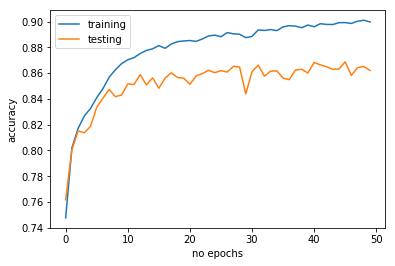

In [15]:
import matplotlib.pyplot as plt
plt.plot(range(no_epochs), train_accuracies, label='train')
plt.plot(range(no_epochs), test_accuracies)
plt.xlabel('no epochs')
plt.ylabel('accuracy')
plt.legend(['training', 'testing'], loc='upper left')

plt.show()